# |In this notebook we fit a SEIR model with hidden states to the Russia Covid-19 data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm
from copy import deepcopy

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [6]:
from sir_models.seir_hidden import SEIRHidden, HiddenCurveFitter
from sir_models.utils import stepwise, eval_one_day_ahead, eval_k_days_ahead

# Load data

In [7]:
DATASET_PATH = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/owid-covid-data.csv'
df = pd.read_csv(DATASET_PATH)

In [8]:

useless_columns = ['iso_code', 'continent',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
        'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',  'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions',
                   'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
                  ]
df = df.drop(columns=useless_columns)
df.date = pd.to_datetime(df.date)

df = df[df.location == 'Russia']

df['total_deaths'] = df.total_deaths.fillna(0)
df['new_deaths'] = df.new_deaths.fillna(0)
df.head().T

,52406,52407,52408,52409,52410
location,Russia,Russia,Russia,Russia,Russia
date,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00
total_cases,2,2,2,2,2
new_cases,2,0,0,0,0
new_cases_smoothed,NaN,NaN,NaN,NaN,NaN
total_deaths,0,0,0,0,0
new_deaths,0,0,0,0,0
new_deaths_smoothed,NaN,NaN,NaN,NaN,NaN
reproduction_rate,NaN,NaN,NaN,NaN,NaN
new_tests,NaN,NaN,NaN,NaN,NaN


# Define model and fitter

In [9]:
class SEIRHidden_OWID(SEIRHidden):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
        params['base_population'].value = df.iloc[0].population
        return params


# Model

In [10]:
train_subset = df[
                #(df.date >= '2020-03-25') & 
                  (df.date <= '2020-11-30')]
train_subset.head()

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,new_tests,total_tests,new_tests_smoothed,positive_rate,tests_per_case,tests_units,population
52406,Russia,2020-01-31,2.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
52407,Russia,2020-02-01,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
52408,Russia,2020-02-02,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
52409,Russia,2020-02-03,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
52410,Russia,2020-02-04,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0


In [11]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

52711   2020-12-01
52712   2020-12-02
52713   2020-12-03
Name: date, dtype: datetime64[ns]

In [12]:
stepwize_size = 60
model = SEIRHidden_OWID(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     total_deaths_col='total_deaths',
     new_deaths_col='new_deaths_smoothed',
     total_cases_col='total_cases',
     new_cases_col='new_cases_smoothed',
#      brute_params=['epidemic_started_days_ago']
)
fitter.fit(model, train_subset)

In [13]:
result = fitter.result
result

In [14]:
train_initial_conditions = fitter.get_initial_conditions(model, train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

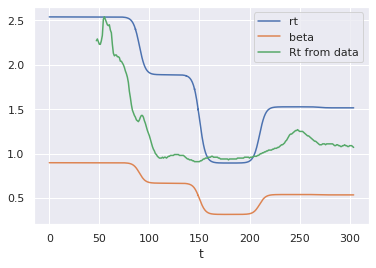

In [15]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.plot(train_t, train_subset.reproduction_rate, label='Rt from data')
plt.legend()
plt.show()

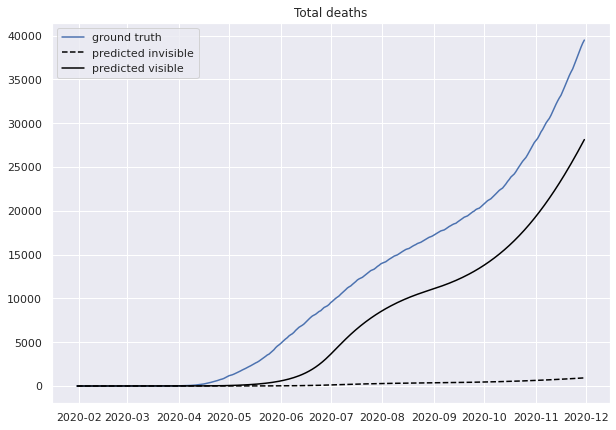

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

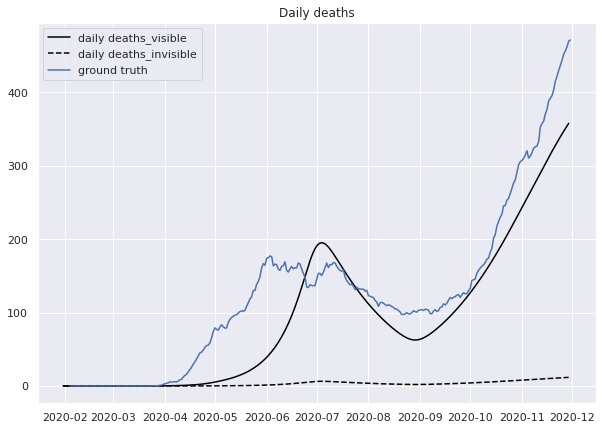

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')

plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')

plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

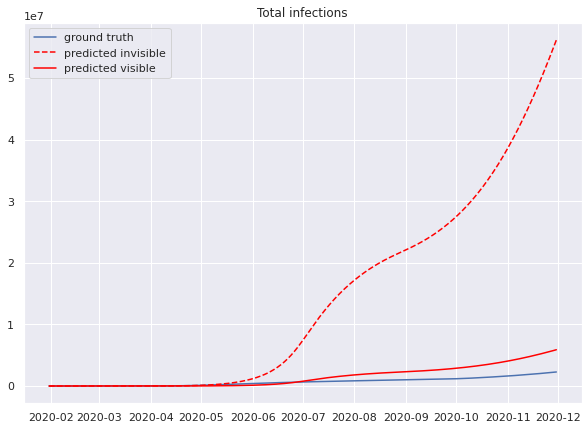

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='ground truth')
plt.plot(train_subset.date, I.cumsum(), label='predicted invisible', color='red', linestyle='dashed' )
plt.plot(train_subset.date, Iv.cumsum(), label='predicted visible', color='red')
plt.legend()
plt.title('Total infections')
plt.show()

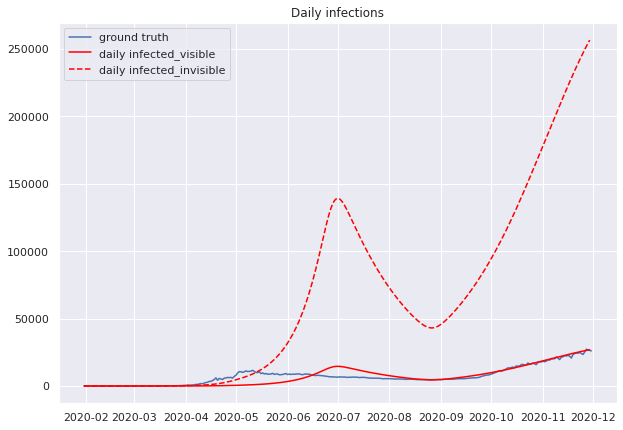

In [19]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases'], label='ground truth')

plt.plot(train_subset.date[:-1], new_infected_visible, label='daily infected_visible', color='red')

plt.plot(train_subset.date[:-1], new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

# Obtain forecast

In [20]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [21]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [22]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [23]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv), history = model.predict(test_t, test_initial_conds)

In [24]:
(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = model.compute_daily_values(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv)

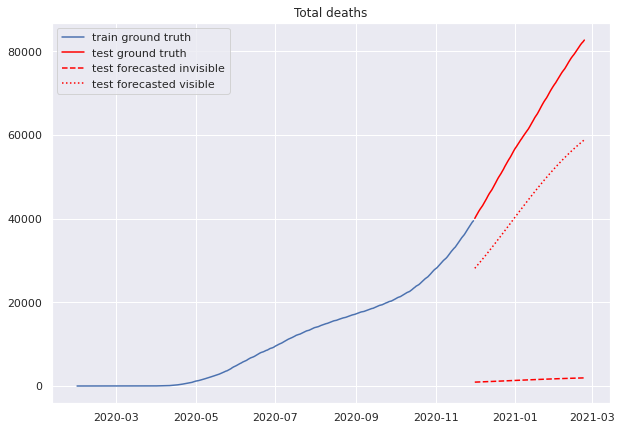

In [25]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='train ground truth')
# plt.plot(train_subset.date, D, label='train fit invisible')

plt.plot(test_subset.date, test_subset['total_deaths'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

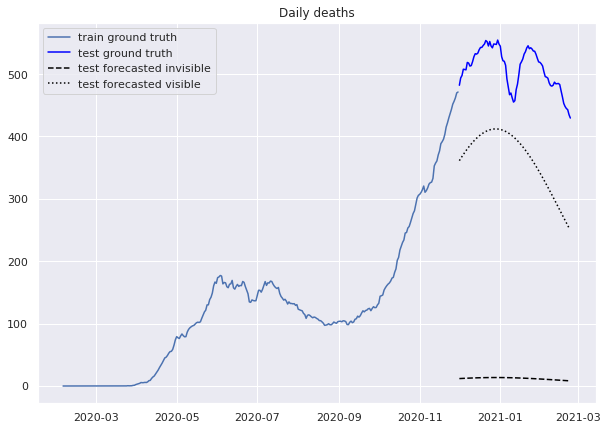

In [26]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='train ground truth')

plt.plot(test_subset.date, test_subset['new_deaths_smoothed'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_dead_invisible, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_dead_visible, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Daily deaths')
plt.show()

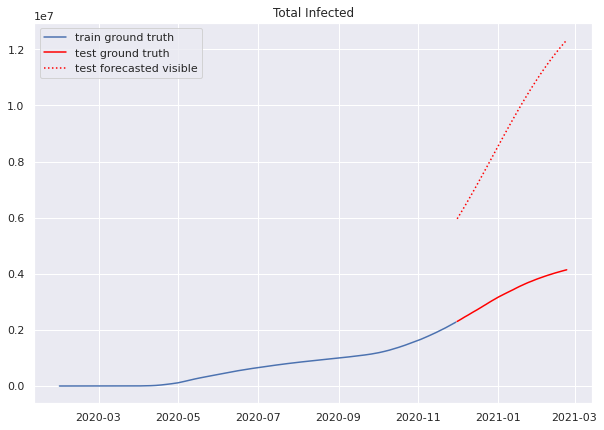

In [27]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='train ground truth')
# plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, test_subset['total_cases'], label='test ground truth', color='red')
# plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, Iv.sum()+test_Iv.cumsum(), label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total Infected')
plt.show()

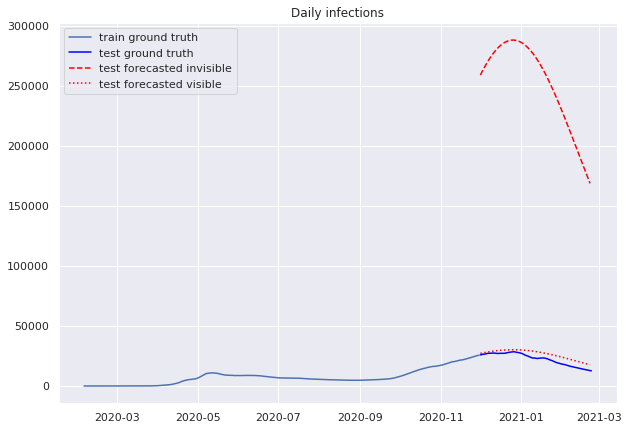

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases_smoothed'], label='train ground truth')

plt.plot(test_subset.date, test_subset['new_cases_smoothed'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_infected_invisible, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_infected_visible, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Daily infections')
plt.show()

# 7-day ahead evaluate

In [29]:
# eval_one_day_ahead(df, SEIRHidden_OWID, HiddenCurveFitter, eval_period_start='2020-05-01', n_eval_points=10, total_dead_col='total_deaths', 
#                    model_kwargs={'stepwise_size': 60}, fitter_kwargs={'verbose': True}, deaths_index_in_compartments=7)

In [34]:
from sklearn.metrics import mean_absolute_error

In [35]:
def rel_error(true, pred):
    return (true - pred) / (true + 1e-10)

In [36]:
eval_period_start_t = len(df[df.date < '2020-05-01'])

In [37]:
pred_dates, baseline_pred_D, model_pred_D, true_D = eval_k_days_ahead(df, 
                  SEIRHidden_OWID, 
                  HiddenCurveFitter, 
                  eval_period_start=eval_period_start_t, 
                  n_eval_points=10, 
                  total_dead_col='total_deaths', 
                  model_kwargs={'stepwise_size': 60}, 
                  fitter_kwargs=dict(verbose=True,
                                     total_deaths_col='total_deaths',
                                     new_deaths_col='new_deaths_smoothed',
                                     total_cases_col='total_cases',
                                     new_cases_col='new_cases_smoothed'), 
                  deaths_index_in_compartments=7,
                  k=7)

In [38]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [39]:
print('Mean overall error baseline', np.mean(overall_errors_baseline))
print('Mean overall error model', np.mean(overall_errors_model))

print('Mean point 7 days ahead error baseline', np.mean(point_errors_baseline))
print('Mean point 7 days ahead error model', np.mean(point_errors_model))

Mean overall error baseline 1027.482142857143
Mean overall error model 12051.741799936515
Mean point 7 days ahead error baseline 1818.25
Mean point 7 days ahead error model 12326.256283063256


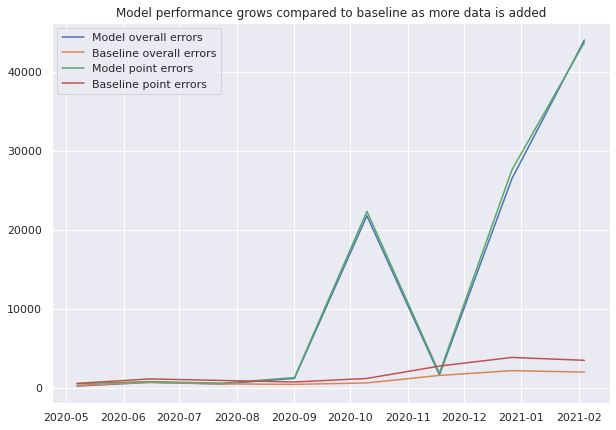

In [43]:
x_dates = [d[-1] for d in pred_dates]

plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors')

plt.plot(x_dates, point_errors_model, label='Model point errors')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors')

plt.legend()
plt.title('Model performance grows compared to baseline as more data is added')
plt.show()

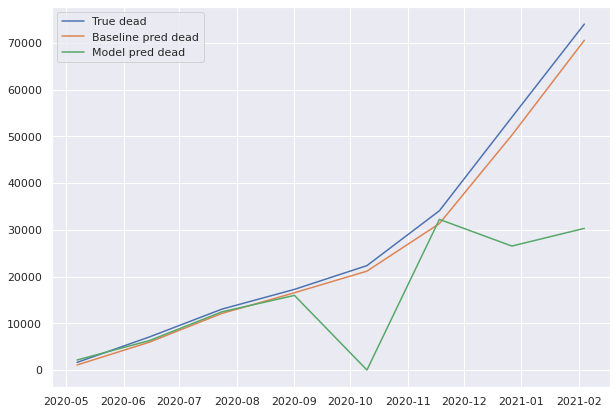

In [44]:
x_dates = [d[-1] for d in pred_dates]

plt.figure(figsize=(10, 7))
plt.plot(x_dates, [v[-1] for v in true_D], label='True dead')
plt.plot(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.plot(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()

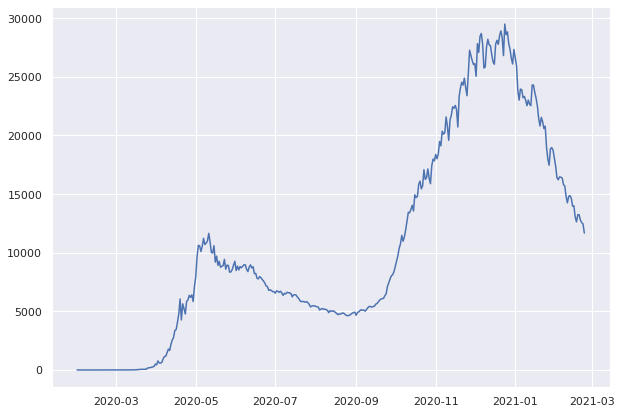

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(df.date, df.new_cases)
plt.show()